<a href="https://colab.research.google.com/github/bryaanabraham/Wandering_Guardian/blob/main/GPS_preprocessing/GPS_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
!pip install gpxpy

In [171]:
!pip install rdp

In [172]:
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp

In [173]:
with open('./ONER_2023_FN.gpx') as fh:
  gpx_file = gpxpy.parse(fh)

In [174]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([
    {'lat': p.latitude,
     'lon': p.longitude,
     'ele': p.elevation,
     'time': p.time,
     } for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head()

,lat,lon,ele
time,,,
None,50.73446,-2.90010,3.400000
None,50.73446,-2.90010,3.400000
None,50.73425,-2.89969,2.200000
None,50.73431,-2.89961,2.175167
None,50.73427,-2.89954,2.156287


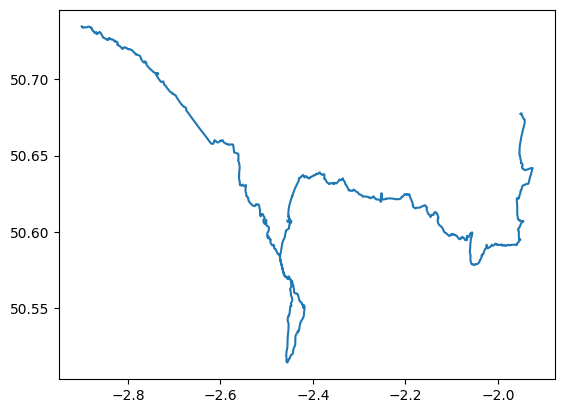

In [175]:
plt.plot(coords['lon'].values, coords['lat'].values)

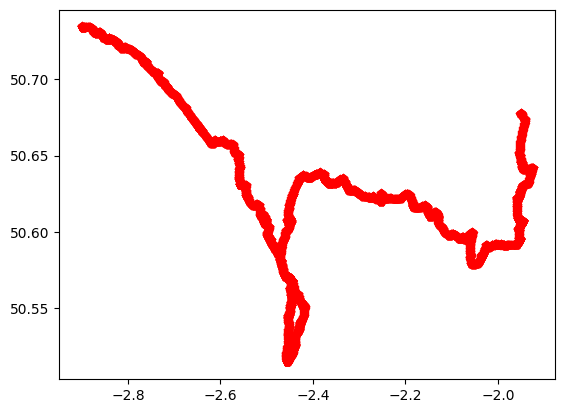

In [176]:
plt.plot(coords['lon'].values, coords['lat'].values, 'rp')

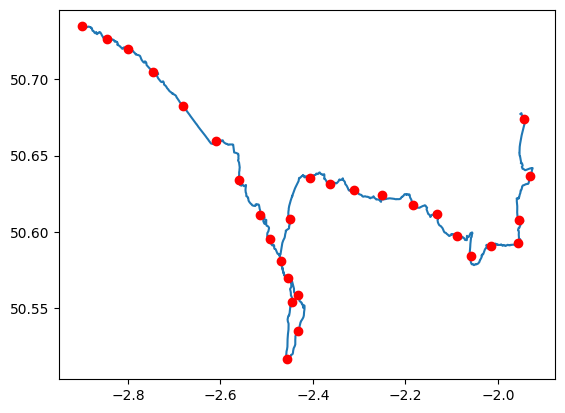

In [177]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values[::150], coords['lat'].values[::150], 'ro')

4223 points reduced to 185


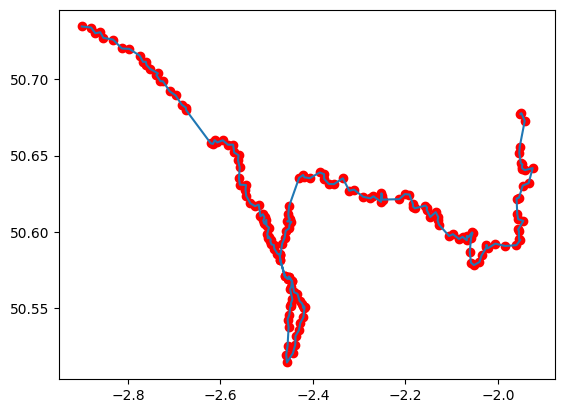

In [178]:
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon = 1e-3)
print("{} points reduced to {}".format(coords.shape[0], simple_coords.shape[0]))
fig = plt.figure()
plt.plot(simple_coords[:,0], simple_coords[:,1],'ro')
plt.plot(simple_coords[:,0], simple_coords[:,1]);

In [179]:
import folium
from folium.plugins import HeatMap
import base64

# Create a Folium map
m = folium.Map()

# Convert the Matplotlib figure to a base64-encoded image
import io
figfile = io.BytesIO()
fig.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
figdata_png_base64 = figdata_png.decode()

# Embed the base64-encoded image data into an HTML file
html = f'<img src="data:image/png;base64,{figdata_png_base64}" alt="Matplotlib Figure">'

# Save the HTML content to a file
with open('figure.html', 'w') as f:
    f.write(html)

# Add the HTML file as an IFrame to the map
iframe = folium.IFrame(html=open('figure.html', 'r').read(), width=fig.get_figwidth(), height=fig.get_figheight())
popup = folium.Popup(iframe, max_width=2650)
folium.Marker(location=[coords['lat'].mean(), coords['lon'].mean()], popup=popup).add_to(m)

# Define GPS path coordinates (assuming you have them stored in a DataFrame 'gps_data' with columns 'lat' and 'lon')
gps_path = list(zip(coords['lat'], coords['lon']))

# Add GPS path as a polyline to the map
folium.PolyLine(locations=gps_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Calculate bounding box of GPS path coordinates
max_lat = max(coords['lat'])
min_lat = min(coords['lat'])
min_lon = min(coords['lon'])
max_lon = max(coords['lon'])

# Set map's zoom and center to show only the GPS path
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])

# Display the map
m


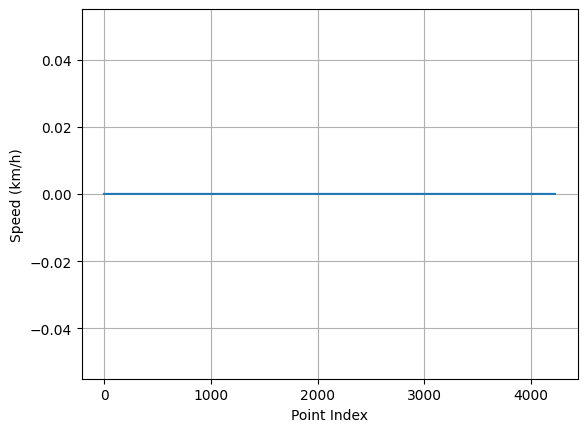

In [180]:
#speed is constant in this data set so this is irrelevant
segment.points[0].speed, segment.points[-1].speed = 0., 0.
gpx_file.add_missing_speeds()
speed = np.array([p.speed * 3.6 if p.speed is not None else 0.0 for p in segment.points])
import matplotlib.pyplot as plt

plt.plot(speed)
plt.xlabel('Point Index')
plt.ylabel('Speed (km/h)')
plt.grid(True)
plt.show()


4223 points reduced to 185


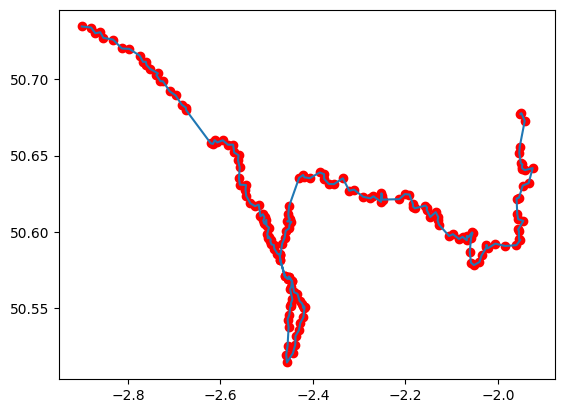

In [181]:
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon = 1e-3)
print("{} points reduced to {}".format(coords.shape[0], simple_coords.shape[0]))
fig = plt.figure()
plt.plot(simple_coords[:,0], simple_coords[:,1],'ro')
plt.plot(simple_coords[:,0], simple_coords[:,1]);

In [223]:
# Define deviation parameters
min_deviation_distance = -0.0003  # Minimum deviation distance
max_deviation_distance = 0.0003   # Maximum deviation distance
max_deviation_angle = 45         # Maximum deviation angle in degrees

# Generate random deviation distances and angles for each point in the DataFrame
num_points = len(coords)
random_deviation_distances = np.random.uniform(min_deviation_distance, max_deviation_distance, num_points)
random_deviation_angles = np.random.uniform(0, max_deviation_angle, num_points)  # Random angles between 0 and max_deviation_angle

# Convert random angles to radians
random_deviation_angles_radians = np.radians(random_deviation_angles)

# Calculate deviation in latitude and longitude for each point
deviation_distance_lat = random_deviation_distances * np.cos(random_deviation_angles_radians)
deviation_distance_lon = random_deviation_distances * np.sin(random_deviation_angles_radians)

# Apply deviation to the existing GPS data
decoy_coords = coords.copy()  # Create a copy of existing coordinates
decoy_coords['lat'] += deviation_distance_lat
decoy_coords['lon'] += deviation_distance_lon

# Display the first few rows of the decoy coordinates
print(decoy_coords.head())


            lat       lon       ele
time                               
None  50.734650 -2.899976  3.400000
None  50.734384 -2.900162  3.400000
None  50.734300 -2.899684  2.200000
None  50.734147 -2.899765  2.175167
None  50.734456 -2.899517  2.156287


4223 points reduced to 207


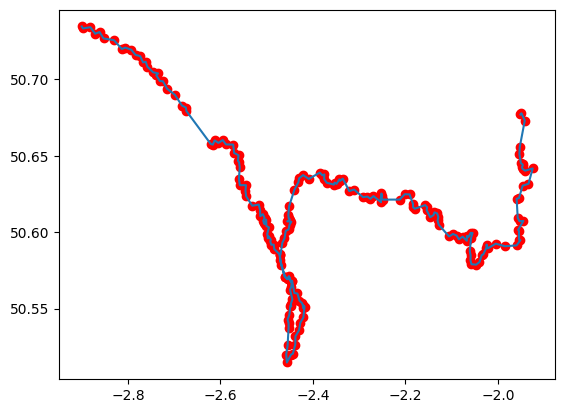

In [224]:
simple_coords = rdp(decoy_coords[['lon', 'lat']].values, epsilon = 1e-3)
print("{} points reduced to {}".format(decoy_coords.shape[0], simple_coords.shape[0]))
fig = plt.figure()
plt.plot(simple_coords[:,0], simple_coords[:,1],'ro')
plt.plot(simple_coords[:,0], simple_coords[:,1]);

In [225]:
import folium

# Create a Folium map with the coordinates from the 'coords' dataframe
m = folium.Map(location=[coords['lat'].mean(), coords['lon'].mean()], zoom_start=10)

# Define GPS path coordinates for 'coords' (assuming you have them stored in a DataFrame 'coords' with columns 'lat' and 'lon')
coords_path = list(zip(coords['lat'], coords['lon']))

# Add GPS path for 'coords' as a polyline to the map (in blue color)
folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Define GPS path coordinates for 'decoy_coords' (assuming you have them stored in a DataFrame 'decoy_coords' with columns 'lat' and 'lon')
decoy_path = list(zip(decoy_coords['lat'], decoy_coords['lon']))

# Add GPS path for 'decoy_coords' as a polyline to the map (in red color)
folium.PolyLine(locations=decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)

# Display the map
m
